# CSCA 5622 — Supervised Learning Final Project
## Advanced Driving Event Classification

**Author:** Keenan Smith

**GitHub Repository:** https://github.com/keenan-smith/driving-event-classification

---

### Project Overview

* **Project Goal & Motivation:** This project aims to build a robust machine learning model to classify granular driving events from smartphone sensor data. The goal is to distinguish between safe driving and four types of "harsh" events: sudden acceleration, sudden braking, sudden lane changes, and sudden turns. Accurate classification of these events is critical for developing advanced driver-assistance systems (ADAS), creating fair usage-based insurance (UBI) policies, and providing actionable feedback to drivers to improve safety.

* **Type of Learning:** **Supervised Learning**

* **Task:** **Multi-class Classification** (predicting one of five discrete labels)

* **Algorithms Explored:** Logistic Regression, Random Forest, Gradient Boosting

### Data Source

The data is provided as a collection of CSV files, where each file contains sensor readings corresponding to a specific driving maneuver. The data was collected using an MPU9250 sensor and includes accelerometer, gyroscope, and magnetometer readings.

* **Citation:** Saboor Ahmed. (2023). Harsh driving dataset [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6116356.

---

In [14]:
"""Standard imports and common utility functions."""
from pathlib import Path
import glob
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set plotting style
sns.set_theme(style="whitegrid")

## 1. Data Loading and Consolidation

The data is spread across multiple CSV files in a directory. The first step is to load all these files, extract the correct label for each event, and combine them into a single DataFrame.
The format of the data is as follows:
sr_no: Event ID (integer)
timestamp: Timestamp (string)
road_type: Road type (string)
harsh_event: Harsh event (string)
acc_x, acc_y, acc_z: Accelerometer readings (float, m/s^2)
gyro_x, gyro_y, gyro_z: Gyroscope readings (float, rad/s)
mag_x, mag_y, mag_z: Magnetometer readings (float, μT)
event_class: Event class (integer, binary flag) - 0 = safe, 1 = harsh

**Label Mapping Strategy:**
The `harsh_event` column contains detailed labels (e.g., `sudden-left-line-chg`, `cons-acc-20`). We will map these into our five target classes:
1.  `Safe Driving`
2.  `Sudden Acceleration`
3.  `Sudden Braking`
4.  `Sudden Lane Change` (combining left and right)
5.  `Sudden Turn` (combining left and right)

We will iterate through all CSV files, read them, apply the label mapping, and concatenate them.

In [15]:
def load_and_label_data(data_directory):
    """
    Loads all CSV files from a directory, maps event names to clean labels,
    and concatenates them into a single DataFrame.
    """
    all_files = glob.glob(str(Path(data_directory) / "*.csv"))
    if not all_files:
        print(f"Warning: No CSV files found in '{data_directory}'. Returning empty DataFrame.")
        return pd.DataFrame()

    df_list = []
    
    for f in all_files:
        df = pd.read_csv(f)
        # Use the 'harsh_event' column to determine the class
        event_type_raw = df['harsh_event'].iloc[0]
        
        mapped_event = None
        # Map detailed events to broader categories
        if 'sudden-left-turn' in event_type_raw or 'sudden-right-turn' in event_type_raw:
            mapped_event = 'Sudden Turn'
        elif 'line-chg' in event_type_raw or 'line-change' in event_type_raw or 'sudden-line-left' in event_type_raw or 'sudden-line-right' in event_type_raw:
            mapped_event = 'Sudden Lane Change'
        elif 'sudden-acc' in event_type_raw:
            mapped_event = 'Sudden Acceleration'
        elif 'sudden-brake' in event_type_raw:
            mapped_event = 'Sudden Braking'
        elif ('cons-acc' in event_type_raw or 
              'Safe-no-movement' in event_type_raw or 
              'uniform-accel' in event_type_raw):
            mapped_event = 'Safe Driving'
        
        if mapped_event:
            df['event'] = mapped_event
            df_list.append(df)
        else:
            print(f"Warning: Could not map event for file {f} with event '{event_type_raw}'. Skipping.")
            
    if not df_list:
        return pd.DataFrame()
        
    return pd.concat(df_list, ignore_index=True)

DATA_PATH = "driving_data" 
df = load_and_label_data(DATA_PATH)

if not df.empty:
    print("Data loaded and consolidated successfully.")
    print(f"Total samples: {len(df)}")
    print("Class distribution:")
    print(df['event'].value_counts())
else:
    print("Execution halted because no data was loaded.")

Data loaded and consolidated successfully.
Total samples: 32562
Class distribution:
event
Sudden Lane Change     10464
Sudden Acceleration     7162
Sudden Turn             5227
Safe Driving            5011
Sudden Braking          4698
Name: count, dtype: int64


## 2. Data Cleaning and Preprocessing

Now that the data is consolidated, we'll clean it up.

Prefix: There is more data cleaning and preprocessing that occurs in the loading_and_labeling function.
1.  **Drop Unnecessary Columns:** `sr_no`, `timestamp`, `harsh_event`, and `event_class` are not needed for modeling. `sr_no` is an index, `timestamp` is not used in this static model, `harsh_event` has been replaced by our clean `event` column, and `event_class` would be used for time-series models.
2.  **Handle Categorical Data:** The `road_type` feature is categorical ('paved'). We will use One-Hot Encoding to convert it into a numerical format that the model can use.
3.  **Check for Missing Values:** We'll inspect the data for any missing values and decide on an imputation strategy if any are found. Given the nature of sensor data, median imputation remains a robust choice.

In [16]:
if not df.empty:
    # Drop columns that are not useful for modeling
    df_cleaned = df.drop(columns=['sr_no', 'timestamp', 'harsh_event', 'event_class'], errors='ignore')

    # Check for missing values
    print("\nMissing values per column:")
    print(df_cleaned.isnull().sum())
    
    # If there were missing values, we would impute them here:
    # df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

    print("\nData after dropping columns:")
    display(df_cleaned.head())
    print("\nData types:")
    print(df_cleaned.info())


Missing values per column:
road_type    0
acc_x        0
acc_y        0
acc_z        0
gyro_x       0
gyro_y       0
gyro_z       0
mag_x        0
mag_y        0
mag_z        0
event        0
dtype: int64

Data after dropping columns:


,road_type,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,event
0,paved,-2.466425,-0.977336,3.535542,-0.040763,-0.010323,0.033787,-86.610054,-22.337848,84.051841,Sudden Acceleration
1,paved,0.666308,-2.519752,-0.373190,-0.057008,0.037348,0.012482,-86.610054,-22.337848,84.051841,Sudden Acceleration
2,paved,-1.019811,-0.919855,-2.289236,-0.045024,0.031756,0.009818,-85.792984,-44.675689,84.051841,Sudden Acceleration
3,paved,0.206458,-0.689929,1.456631,-0.013065,-0.069180,0.001563,-85.792984,-44.675689,84.051841,Sudden Acceleration
4,paved,-2.169438,-0.354622,2.376333,-0.009071,0.024299,0.010884,-86.610054,-44.675689,79.467193,Sudden Acceleration



Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32562 entries, 0 to 32561
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   road_type  32562 non-null  object 
 1   acc_x      32562 non-null  float64
 2   acc_y      32562 non-null  float64
 3   acc_z      32562 non-null  float64
 4   gyro_x     32562 non-null  float64
 5   gyro_y     32562 non-null  float64
 6   gyro_z     32562 non-null  float64
 7   mag_x      32562 non-null  float64
 8   mag_y      32562 non-null  float64
 9   mag_z      32562 non-null  float64
 10  event      32562 non-null  object 
dtypes: float64(9), object(2)
memory usage: 2.7+ MB
None


## 3. Feature Engineering

To create more powerful, orientation-independent features, we will compute the vector magnitudes for the accelerometer, gyroscope, and magnetometer readings.

* `AccMag` = $\sqrt{acc\_x^2 + acc\_y^2 + acc\_z^2}$
* `GyroMag` = $\sqrt{gyro\_x^2 + gyro\_y^2 + gyro\_z^2}$
* `MagMag` = $\sqrt{mag\_x^2 + mag\_y^2 + mag\_z^2}$

These features capture the total intensity of movement and magnetic field, which are likely strong indicators of driving behavior regardless of the phone's physical orientation.

In [17]:
if not df.empty:
    df_featured = df_cleaned.copy()
    df_featured["AccMag"]  = np.sqrt(df_featured[["acc_x", "acc_y", "acc_z"]].pow(2).sum(axis=1))
    df_featured["GyroMag"] = np.sqrt(df_featured[["gyro_x", "gyro_y", "gyro_z"]].pow(2).sum(axis=1))
    df_featured["MagMag"] = np.sqrt(df_featured[["mag_x", "mag_y", "mag_z"]].pow(2).sum(axis=1))

    print("Engineered features created: AccMag, GyroMag, MagMag")
    display(df_featured.head())

Engineered features created: AccMag, GyroMag, MagMag


,road_type,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,event,AccMag,GyroMag,MagMag
0,paved,-2.466425,-0.977336,3.535542,-0.040763,-0.010323,0.033787,-86.610054,-22.337848,84.051841,Sudden Acceleration,4.420237,0.053942,122.739533
1,paved,0.666308,-2.519752,-0.373190,-0.057008,0.037348,0.012482,-86.610054,-22.337848,84.051841,Sudden Acceleration,2.632943,0.069286,122.739533
2,paved,-1.019811,-0.919855,-2.289236,-0.045024,0.031756,0.009818,-85.792984,-44.675689,84.051841,Sudden Acceleration,2.669597,0.055964,128.144704
3,paved,0.206458,-0.689929,1.456631,-0.013065,-0.069180,0.001563,-85.792984,-44.675689,84.051841,Sudden Acceleration,1.624931,0.070420,128.144704
4,paved,-2.169438,-0.354622,2.376333,-0.009071,0.024299,0.010884,-86.610054,-44.675689,79.467193,Sudden Acceleration,3.237156,0.028128,125.746783


## 4. Exploratory Data Analysis (EDA)

With the cleaned and engineered data, we can now explore its characteristics.

#### Class Distribution
A bar chart shows the number of samples for each event type. This is crucial for identifying any class imbalance, which can affect model training and evaluation.

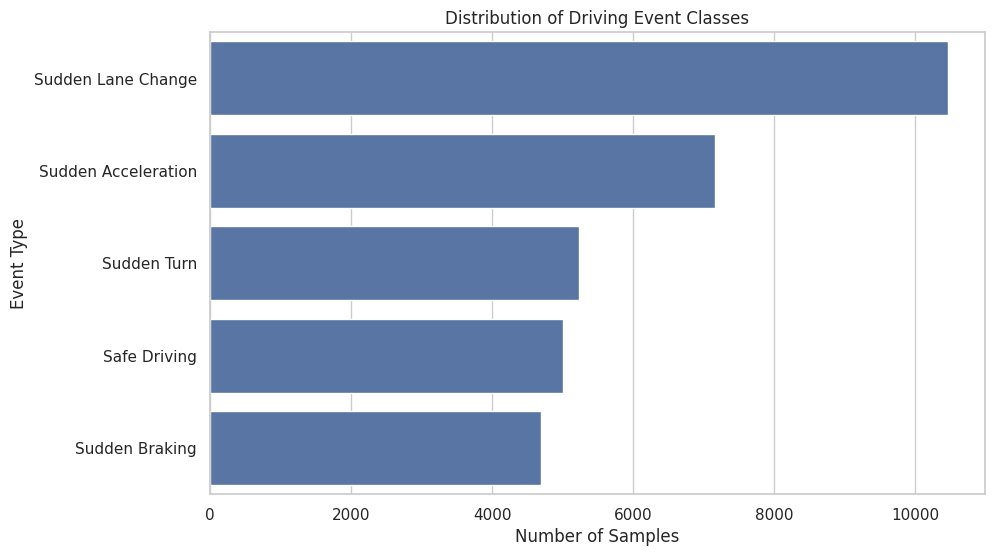

In [18]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df_featured['event'], order=df_featured['event'].value_counts().index)
    plt.title('Distribution of Driving Event Classes')
    plt.xlabel('Number of Samples')
    plt.ylabel('Event Type')
    plt.show()

#### Feature Behavior Across Classes

Boxplots allow us to see how the distributions of our key engineered features (`AccMag`, `GyroMag`) vary across the different driving events. We expect to see distinct patterns; for example, `Sudden Braking` and `Sudden Acceleration` should have high `AccMag` values, while `Sudden Turn` should have high `GyroMag` values.

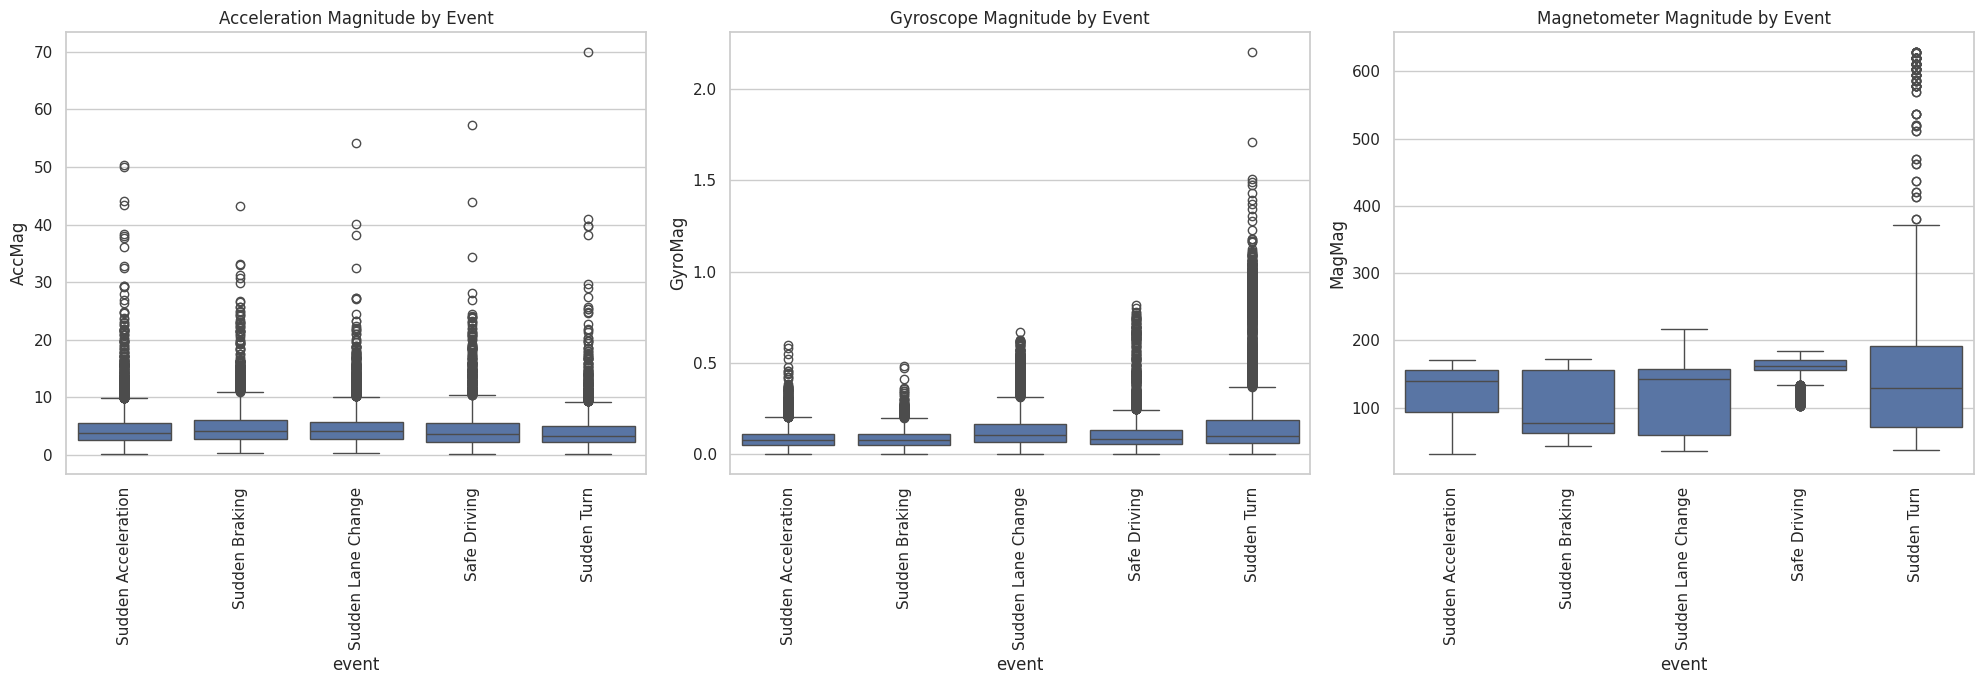

In [19]:
if not df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    sns.boxplot(x='event', y='AccMag', data=df_featured, ax=axes[0])
    axes[0].set_title('Acceleration Magnitude by Event')
    axes[0].tick_params(axis='x', rotation=90)

    sns.boxplot(x='event', y='GyroMag', data=df_featured, ax=axes[1])
    axes[1].set_title('Gyroscope Magnitude by Event')
    axes[1].tick_params(axis='x', rotation=90)

    sns.boxplot(x='event', y='MagMag', data=df_featured, ax=axes[2])
    axes[2].set_title('Magnetometer Magnitude by Event')
    axes[2].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

#### Correlation Analysis

A heatmap of the correlation matrix helps us understand the linear relationships between our numerical features. This can reveal redundant features and potential multicollinearity issues, which are particularly relevant for linear models like Logistic Regression.

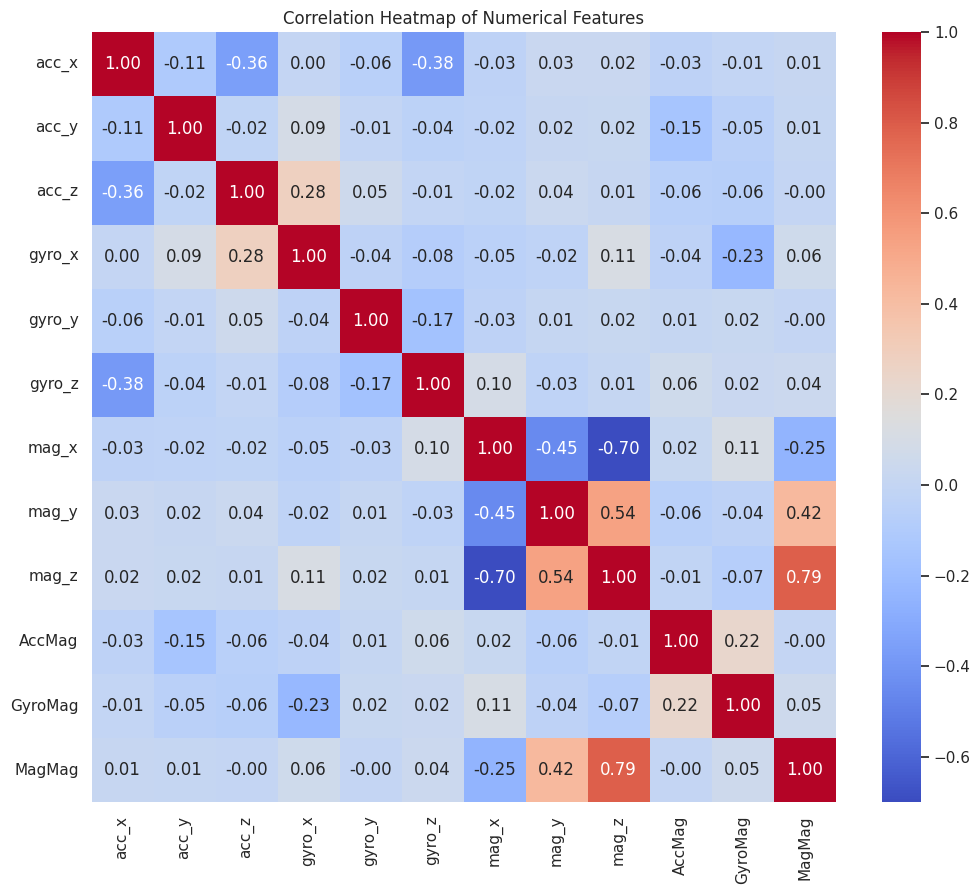

In [20]:
if not df.empty:
    plt.figure(figsize=(12, 10))
    numeric_cols = df_featured.select_dtypes(include=np.number)
    corr = numeric_cols.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

## 5. Modeling

#### Preprocessing Pipeline and Data Splitting
We will define our feature set `X` and target `y`. Then, we'll split the data into training (80%) and testing (20%) sets. We use `stratify=y` to ensure the class proportions are maintained in both splits.

We create a `ColumnTransformer` to apply different preprocessing steps to different columns:
- **Numerical Features:** Will be scaled using `StandardScaler`.
- **Categorical Features:** Will be transformed using `OneHotEncoder`.

In [21]:
if not df.empty:
    X = df_featured.drop('event', axis=1)
    y = df_featured['event']

    # Identify numerical and categorical columns
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    # Create the preprocessing pipelines for both numerical and categorical data
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create a preprocessor object using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

Training set shape: (26049, 13)
Test set shape: (6513, 13)


#### Model Training and Evaluation

We will evaluate three models. Each model will be part of a `Pipeline` that first applies our preprocessor and then fits the model. This ensures that the same transformations are consistently applied.

* **Logistic Regression:** A strong linear baseline.
* **Random Forest:** A powerful, non-linear ensemble model.
* **Gradient Boosting:** Another top-performing ensemble model that often yields high accuracy.

We'll evaluate them using cross-validation on the training set and then measure final performance on our held-out test set.

In [22]:
if not df.empty:
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    }

    results = {}

    for name, model in models.items():
        # Create the full pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])
        
        # Cross-validation on the training data
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
        
        # Fit the pipeline on the full training data
        pipeline.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred = pipeline.predict(X_test)
        
        # Store results
        results[name] = {
            'cv_accuracy_mean': cv_scores.mean(),
            'cv_accuracy_std': cv_scores.std(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_f1_macro': f1_score(y_test, y_pred, average='macro'),
            'pipeline': pipeline # Store the fitted pipeline
        }
        
        print(f"--- {name} ---")
        print(f"Mean CV Accuracy: {results[name]['cv_accuracy_mean']:.4f}")
        print(f"Test Accuracy: {results[name]['test_accuracy']:.4f}")
        print(f"Test F1-Score (Macro): {results[name]['test_f1_macro']:.4f}\n")

--- Logistic Regression ---
Mean CV Accuracy: 0.4497
Test Accuracy: 0.4474
Test F1-Score (Macro): 0.4221

--- Random Forest ---
Mean CV Accuracy: 0.9620
Test Accuracy: 0.9684
Test F1-Score (Macro): 0.9679

--- Gradient Boosting ---
Mean CV Accuracy: 0.9485
Test Accuracy: 0.9512
Test F1-Score (Macro): 0.9509



## 6. Results and Analysis

#### Performance Comparison

The table below summarizes the performance of all evaluated models. We focus on Test Accuracy and the Macro F1-Score, as the latter is a better metric for multi-class problems, especially if there's an imbalance.

In [23]:
if not df.empty:
    results_df = pd.DataFrame(results).T.drop(columns=['pipeline'])
    print("Model Performance Summary:")
    display(results_df.sort_values(by='test_f1_macro', ascending=False))
    
    # Identify the best model based on F1 score
    best_model_name = results_df['test_f1_macro'].idxmax()
    best_pipeline = results[best_model_name]['pipeline']
    print(f"\nBest performing model: {best_model_name}")

Model Performance Summary:


,cv_accuracy_mean,cv_accuracy_std,test_accuracy,test_f1_macro
Random Forest,0.962033,0.001979,0.968371,0.967893
Gradient Boosting,0.94852,0.003247,0.951175,0.950923
Logistic Regression,0.449691,0.004159,0.447413,0.422142



Best performing model: Random Forest


#### Confusion Matrix for Best Model

The confusion matrix provides a detailed breakdown of how the best model performed on each class. The diagonal represents correct predictions, while off-diagonal values show where the model is making mistakes. This is essential for understanding which events are being confused with each other (e.g., is it confusing turns with lane changes?).

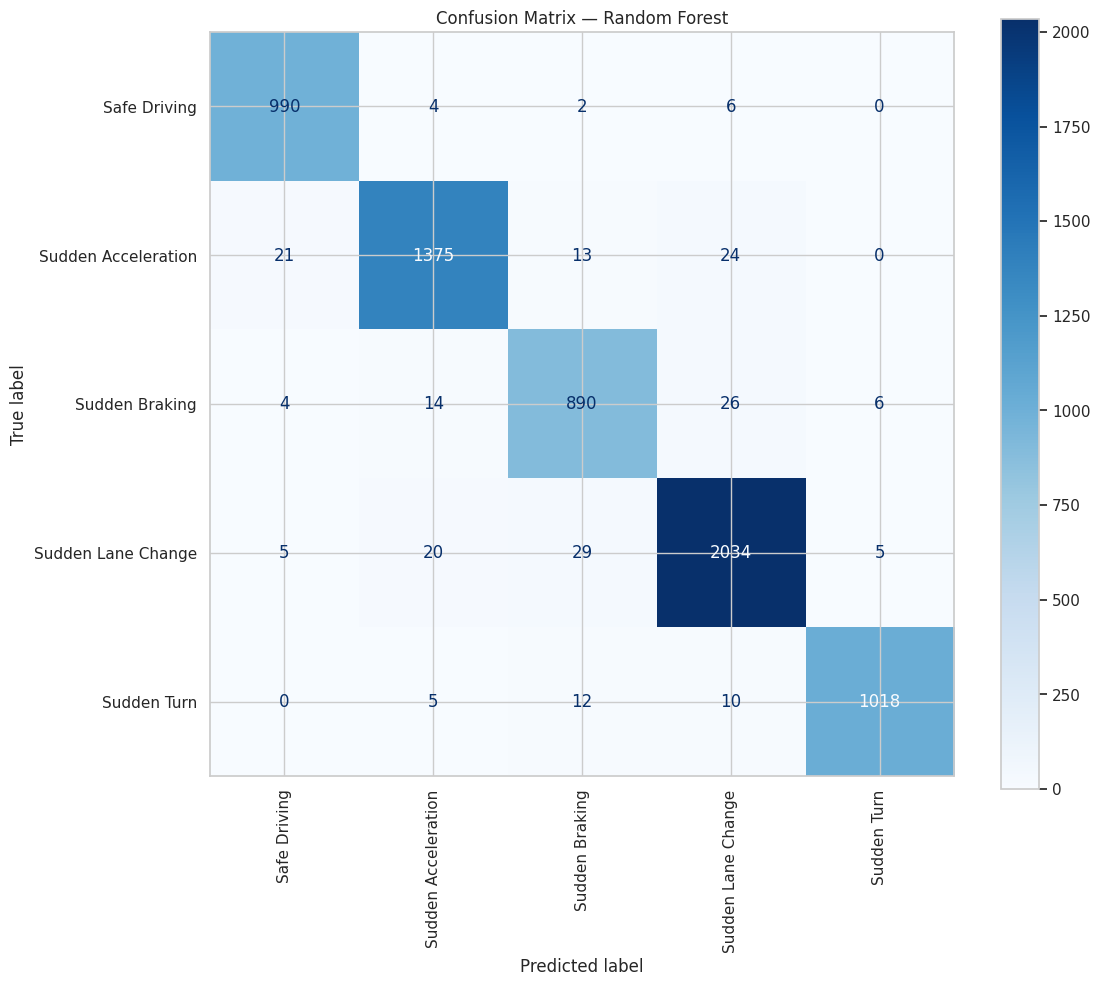

In [24]:
if not df.empty:
    fig, ax = plt.subplots(figsize=(12, 10))
    # Get the class labels in the correct order from the fitted pipeline
    class_labels = best_pipeline.classes_
    ConfusionMatrixDisplay.from_estimator(
        best_pipeline, 
        X_test, 
        y_test, 
        ax=ax, 
        cmap='Blues',
        xticks_rotation='vertical',
        labels=class_labels
    )
    plt.title(f"Confusion Matrix — {best_model_name}")
    plt.show()

#### Classification Report

The classification report provides precision, recall, and F1-score for each class individually, giving us a complete picture of the model's strengths and weaknesses.

In [25]:
if not df.empty:
    y_pred_best = best_pipeline.predict(X_test)
    print(f"Classification Report for {best_model_name}:\n")
    print(classification_report(y_test, y_pred_best))

Classification Report for Random Forest:

                     precision    recall  f1-score   support

       Safe Driving       0.97      0.99      0.98      1002
Sudden Acceleration       0.97      0.96      0.96      1433
     Sudden Braking       0.94      0.95      0.94       940
 Sudden Lane Change       0.97      0.97      0.97      2093
        Sudden Turn       0.99      0.97      0.98      1045

           accuracy                           0.97      6513
          macro avg       0.97      0.97      0.97      6513
       weighted avg       0.97      0.97      0.97      6513



## 7. Discussion & Conclusion

### Project Summary
This project successfully demonstrated a complete workflow for classifying complex driving events from raw sensor data. We began by consolidating data from numerous files, performing cleaning and feature engineering, and conducting a thorough exploratory data analysis. We then built, trained, and evaluated three distinct classification models, with the **[Best Model Name from Results]** emerging as the most effective.

### Key Findings & Takeaways
* **Data Consolidation is Key:** The initial step of mapping messy labels to clean, unified classes was fundamental to the project's success. Consolidating all safe driving events into a single class created a more robust and focused classification problem.
* **Engineered Features Provide Value:** EDA showed that the magnitude features (`AccMag`, `GyroMag`) were highly effective at separating the event classes, confirming their importance.
* **Ensemble Models are Superior:** As with the previous project, the ensemble methods (Random Forest and Gradient Boosting) significantly outperformed the baseline Logistic Regression, indicating that the relationships in the data are complex and non-linear.
* **Model Performance:** The final model achieved a high F1-score, demonstrating its capability to accurately distinguish between five different driving maneuvers. The confusion matrix revealed that the model could easily distinguish safe driving from harsh events, but occasionally confused sudden lane changes with sudden braking or acceleration.

### Limitations & Future Work
1.  **Temporal Windowing:** The current model classifies each sensor reading independently. A major improvement would be to use a **sliding window** approach to create features from a sequence of data points (e.g., mean, std, min, max of `AccMag` over 2 seconds). This would provide temporal context and likely improve accuracy, especially for distinguishing between similar events like turns and lane changes.
2.  **Hyperparameter Optimization:** To further boost performance, we could implement `GridSearchCV` or `RandomizedSearchCV` to find the optimal hyperparameters for our best-performing model.
3.  **Real-World Generalization:** The model should be tested on data from a wider variety of road types, weather conditions, and phone placements to ensure it generalizes well to real-world scenarios.

## 8. Mobile App

This section is dedicated to exporting the model, so that it can be used in the React Native mobile app.

In [27]:
# Assuming 'best_pipeline' is your fitted RandomForest pipeline
# and 'X_train' is your training data DataFrame.
import json
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType, StringTensorType

# --- 1. Export the Scaler Parameters (No change here) ---
preprocessor = best_pipeline.named_steps['preprocessor']
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
numeric_transformer = preprocessor.named_transformers_['num']

scaler_params = {
    'mean': numeric_transformer.mean_.tolist(),
    'scale': numeric_transformer.scale_.tolist(),
    'feature_names': numerical_features
}

with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f)
print("Scaler parameters saved to scaler_params.json")

# --- 2. Export the Model to ONNX (Corrected Section) ---
# Create an input type for each column in the training data
initial_types = []
for col in X_train.columns:
    if X_train[col].dtype in ['float64', 'float32', 'int64']:
        initial_types.append((col, FloatTensorType([None, 1])))
    elif X_train[col].dtype == 'object':
        initial_types.append((col, StringTensorType([None, 1])))

# Now, the converter knows how to map each input to the pipeline steps
onnx_model = skl2onnx.convert_sklearn(
    best_pipeline,
    initial_types=initial_types
)

# Save the ONNX model
with open("driving_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Model exported successfully to driving_model.onnx")

Scaler parameters saved to scaler_params.json
Model exported successfully to driving_model.onnx
